In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            fi_estimate = 2*p0_estimate - 1
            
            signals[i] = np.real(fi_estimate)
        # self.cos_signal = cos_signal
        
        return signals    

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

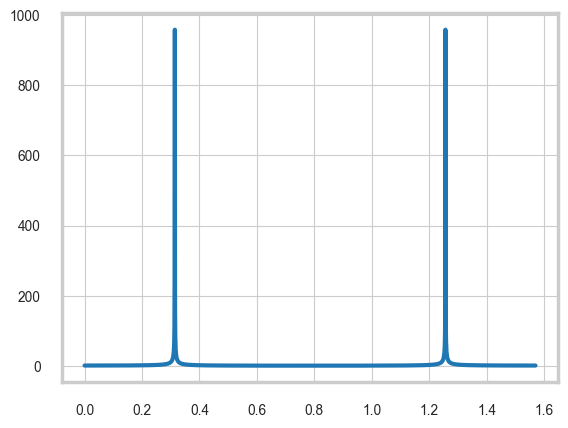

In [233]:
# Set the actual amplitude
a=0.3
theta = np.arccos(a)

theta1 = np.pi/5
theta2 = -theta1#np.pi/4

depths = [i for i in range(2049)]
n_samples = [100 for d in depths]

R = estimate_signal(depths, n_samples, theta)

R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [234]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta1, theta2}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: (0.6283185307179586, -0.6283185307179586)
peaks: 1.2564837382219793 0.31431258857291733


In [361]:
np.cos(np.pi*(len(fft)-amax)/(2*len(fft))), np.cos(np.pi*(amax)/(2*len(fft)))

(0.499546481640743, 0.8662870844473874)

In [235]:
# espirit doesnt always work
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'theta: {theta1, theta2}')
np.sum(np.abs(angle))/8

angles: [-0.62862518  0.62862518]
theta_est: 0.6286251771458347
theta: (0.6283185307179586, -0.6283185307179586)


0.31431258857291733

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

/var/folders/lg/jbb7l6y11_343nxvjxmyhh8h0000gn/T/ipykernel_56602/4285771398.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  R[n] = 0.5*np.exp(1j*w*(2*n+1)) + 0.5*np.exp(-1j*w*(2*n+1))


(1.258207857762712, 0.31258846903218446, 0.6283185307179586)

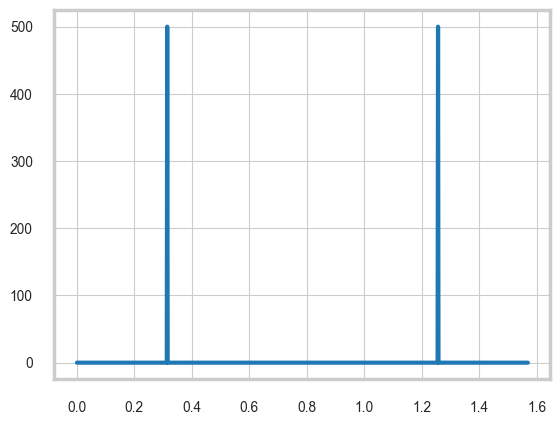

In [254]:
from scipy.special import chebyt

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = 0.5*np.exp(1j*w*(2*n+1)) + 0.5*np.exp(-1j*w*(2*n+1))
        # R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

# theta = 0.5
# w = 2*theta
# a = np.cos(theta)

a = 0.75
theta = np.arccos(a)
theta = np.pi/5
w = 2*theta

d_max = 1000

depths = [i for i in range(d_max)]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [10 for _ in depths]

# R = estimate_signal(depths, n_samples, theta)
# R = get_cheb_vals(d_max, w)
R = get_cosine_values(d_max, theta)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [264]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 0.62894744 -0.62894744]
theta_est: 2.512645213841945
theta:0.6283185307179586


0.6289474397478478

depths:[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
idx_vals:[1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 1025, 2049, 4097, 8193]
{1: 0.38000000000000006, 3: -0.8400000000000001, 5: 1.0, 9: 0.41999999999999993, 17: -0.79, 33: -0.8, 65: 1.0, 129: 0.35000000000000003, 257: -0.81, 513: -0.8, 1025: 1.0, 2049: 0.28, 4097: -0.8, 8193: -0.8}
8192


(0.9802137234589247, 0.5905826033359719, 0.6283185307179586)

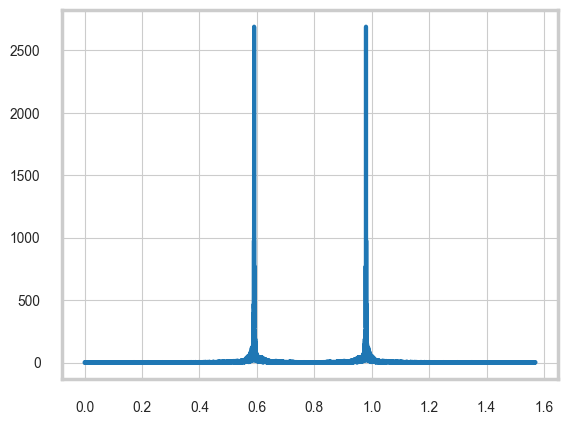

In [316]:
a = 0.1
theta = np.pi/5# np.arccos(a)
w = 2*theta


q = 12
depths = [0, 1]
for k in range(q):
    depths.append(2**(k+1))

idx_vals = []
for d in depths:
    idx_vals.append(2*d+1)

print(f'depths:{depths}')
print(f'idx_vals:{idx_vals}')


n_samples = [100 for _ in depths]

cos_values = {}
for i, depth in enumerate(depths):
    # noisy cos values
    p0 = P0(depth, theta)
    p1 = P1(depth, theta)
    p0_estimate = np.random.binomial(n_samples[i], p0)/n_samples[i]
    p1_estimate = np.random.binomial(n_samples[i], p1)/n_samples[i]
    cos_values[2*depth+1] = p0_estimate - p1_estimate
    # cos_values[2*depth+1] = 2*p0_estimate - 1
    # cos_values[2*depth+1] = 2*np.cos((2*depth+1)*theta)**2 - 1
    # cos_values[2*depth+1] = np.cos((2*depth+1)*w)
    
print(cos_values)

def cheb_recursion(n):
    if n==0:
        return 1
    elif n in cos_values.keys():
        return cos_values[n]
    else:
        cos_values[n] = 2*cheb_recursion(1)*cheb_recursion(n-1)-cheb_recursion(n-2)
        return cos_values[n]
    
for d in range(idx_vals[-1]//2+1):
    cos_values[2*d+1] = cheb_recursion(2*d+1)
print(len(cos_values))

# R is the signal on physical and virtual locations
R = np.zeros(len(cos_values))
for d in range(idx_vals[-1]//2 + 1):
    R[d] = cos_values[2*d+1]

# R = [0.5*np.exp(1j*theta*(2*d+1)) + 0.5*np.exp(-1j*theta*(2*d+1)) for d in range(idx_vals[-1]//2 + 1)]

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [289]:
len(R)

8192

In [319]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 1.18147869 -1.18147869]
w: 1.2566370614359172
theta_est: 0.9800569799155802
theta:0.6283185307179586


1.1814786937586328